In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from pprint import pprint
from preprocessing import mean_and_std

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20480 entries, 0 to 20479
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             20480 non-null  float64
 1   bath            20480 non-null  float64
 2   acre_lot        20480 non-null  float64
 3   zip_code        20480 non-null  float64
 4   house_size      20480 non-null  float64
 5   price           20480 non-null  float64
 6   prev_sold_year  20480 non-null  float64
 7   latitude        20480 non-null  float64
 8   longitude       20480 non-null  float64
 9   county          20480 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.6 MB


In [4]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

8527.0

In [5]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [6]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 10338 to 10606
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             269 non-null    float64
 1   bath            269 non-null    float64
 2   acre_lot        269 non-null    float64
 3   zip_code        269 non-null    float64
 4   house_size      269 non-null    float64
 5   price           269 non-null    float64
 6   prev_sold_year  269 non-null    float64
 7   latitude        269 non-null    float64
 8   longitude       269 non-null    float64
 9   county          269 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 23.1 KB


In [7]:
groupby_county = outliers_df.groupby(["county"])["county"].count().sort_values(ascending=False)
groupby_county_df = pd.DataFrame(groupby_county).rename(columns={"county":"count"}).reset_index()
first_county = groupby_county_df.iloc[0]["county"]
first_county

16

In [8]:
one_county_df = outliers_df[outliers_df["county"].isin([first_county])]

In [9]:
one_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1721 entries, 13052 to 19278
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             1721 non-null   float64
 1   bath            1721 non-null   float64
 2   acre_lot        1721 non-null   float64
 3   zip_code        1721 non-null   float64
 4   house_size      1721 non-null   float64
 5   price           1721 non-null   float64
 6   prev_sold_year  1721 non-null   float64
 7   latitude        1721 non-null   float64
 8   longitude       1721 non-null   float64
 9   county          1721 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 147.9 KB


In [10]:
# "data":one_zipcode_df,
#  "data":outliers_df,
#  "data":one_county_df,


params = {
    "data":one_county_df,
    "features_a":["prev_sold_year","zip_code","latitude","longitude","county"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
#normalize_df = one_county_df
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year,zip_code,latitude,longitude,county
19274,0.840919,-0.198968,-0.099942,-0.103172,0.015082,2012.0,8084.0,39.828957,-75.015458,16
19275,0.840919,-0.198968,-0.086640,0.171126,0.015561,2007.0,8084.0,39.828957,-75.015458,16
19276,-0.295048,-0.198968,-0.142506,-0.135672,-0.535471,2005.0,8084.0,39.828957,-75.015458,16
19277,1.976885,-0.198968,-0.102602,-0.104472,-0.056792,2013.0,8084.0,39.828957,-75.015458,16
19278,0.840919,-0.198968,-0.107922,0.041127,-0.114291,2012.0,8084.0,39.828957,-75.015458,16


In [11]:
#"latitude","longitude","county","zip_code"
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.187205
bed               0.402412
bath              0.564686
house_size        0.646237
prev_sold_year    0.024774
price             1.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Correlation Between Variables')

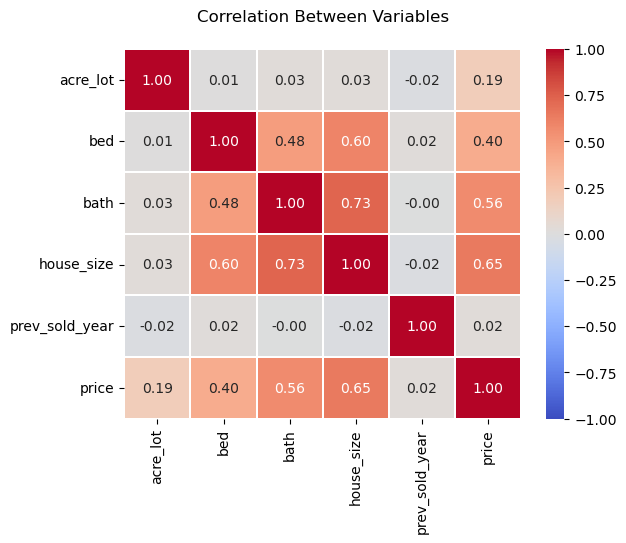

In [12]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

In [13]:
#corrfeatures = ["latitude","longitude"]
corrfeatures = []
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.17:
        corrfeatures.append(feature)
        
savefeatures = list(dict.fromkeys(corrfeatures))
print(savefeatures)

['acre_lot', 'bed', 'bath', 'house_size']


In [14]:
pariplot_features = []
for feature, value in correlation["price"].items():
        pariplot_features.append(feature)

In [15]:
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

In [16]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [17]:
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()), 
    ('poly_model', LinearRegression())
])

poly_degrees = range(1,5,1)

poly_pipeline_params={"poly_features__degree":poly_degrees,"poly_features__include_bias":[False],"poly_model__fit_intercept":[True]}
poly_grid_searchcv = GridSearchCV(poly_pipeline, param_grid=poly_pipeline_params, cv=5, verbose=1)
poly_grid_searchcv.fit(X, y)

poly_grid_searchcv.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'poly_features__degree': 1,
 'poly_features__include_bias': False,
 'poly_model__fit_intercept': True}

In [18]:
poly_best_params = {}
for what in poly_grid_searchcv.best_params_:
    if poly_best_params.get(what) == None:
        poly_best_params[what] = []
    poly_best_params[what].append(poly_grid_searchcv.best_params_[what])

In [19]:
poly_best_params

{'poly_features__degree': [1],
 'poly_features__include_bias': [False],
 'poly_model__fit_intercept': [True]}

In [20]:
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()), 
    ('poly_model', LinearRegression())
])

poly_grid_searchcv = GridSearchCV(poly_pipeline, param_grid=poly_best_params, cv=5, verbose=1)
poly_grid_searchcv.fit(X_train, y_train)

poly_predictions = poly_grid_searchcv.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [21]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

In [22]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

In [23]:
    pms_config = {
        "title":"Polynomial", 
        "y_param":y_test, 
        "predictions":poly_predictions, 
        "gscv":poly_grid_searchcv
    }

In [24]:
results = print_more_stuff(pms_config)

Polynomial EVS = 0.356978504
Polynomial MSE = 0.671132
Polynomial MAE = 0.444563
Polynomial R2 = 0.356612
Polynomial Fit Time = 0.007229042053222656


In [25]:
results_dict_append(results)

In [26]:
predict_df = pd.DataFrame(poly_predictions).reset_index()
predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

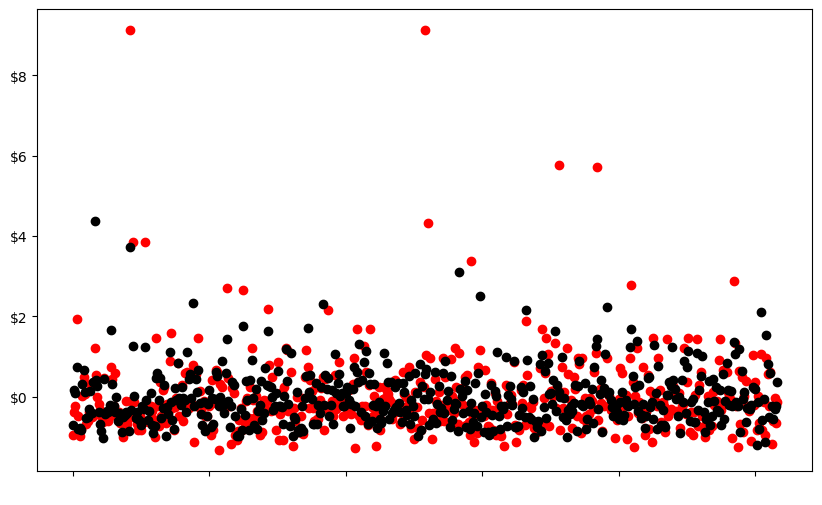

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(predict_df.index,predict_df["prediction"], color="black")
plt.show()

In [28]:
results_dict

{'model': ['Polynomial'],
 'explained variance score': ['0.356978504'],
 'mae score': ['0.444563'],
 'mse score': ['0.671132'],
 'r2 score': ['0.356612'],
 'mean fit time': [0.007229042053222656]}

In [29]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Polynomial,0.356978504,0.444563,0.671132,0.356612,0.007229


In [30]:
not_normlized_features_macro = {'model': ['Polynomial'],
 'explained variance score': ['0.439941932'],
 'mae score': ['200,275.324785'],
 'mse score': ['100,870,089,629.248779'],
 'r2 score': ['0.439677'],
 'mean fit time': [0.010838460922241212]}

not_normlized_features_micro = {'model': ['Polynomial'],
 'explained variance score': ['0.444986054'],
 'mae score': ['160,153.361798'],
 'mse score': ['90,128,097,153.086136'],
 'r2 score': ['0.424667'],
 'mean fit time': [0.0024103164672851563]}

not_normalized_features_county = {'model': ['Polynomial'],
 'explained variance score': ['0.356978504'],
 'mae score': ['92,780.083830'],
 'mse score': ['29,231,433,918.019638'],
 'r2 score': ['0.356612'],
 'mean fit time': [0.004442787170410157]}




normalized_features_county = {'model': ['Polynomial'],
 'explained variance score': ['0.356978504'],
 'mae score': ['0.444563'],
 'mse score': ['0.671132'],
 'r2 score': ['0.356612'],
 'mean fit time': [0.007229042053222656]}

normlized_features_micro = {'model': ['Polynomial'],
 'explained variance score': ['0.444986054'],
 'mae score': ['0.512584'],
 'mse score': ['0.923246'],
 'r2 score': ['0.424667'],
 'mean fit time': [0.001876497268676758]}

normlized_features_macro = {'model': ['Polynomial'],
 'explained variance score': ['0.439941932'],
 'mae score': ['0.480012'],
 'mse score': ['0.579444'],
 'r2 score': ['0.439677'],
 'mean fit time': [0.006977558135986328]}